In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
df = pd.read_csv("mancity23-24.csv")

In [ ]:
# Drop irrelevant columns
df.drop(columns=['Unnamed: 0', 'Date', 'Venue'], inplace=True)

In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
df['Result'] = label_encoder.fit_transform(df['Result'])  # W=2, D=0, L=1

In [ ]:
# One-hot encode categorical features
categorical_cols = ['H/A', 'Competition', 'opponent(opp)']
df = pd.get_dummies(df, columns=categorical_cols)

In [ ]:
# Separate features and label
X = df.drop(columns=['Result'])
y = df['Result']

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# Define neural network
class MatchPredictor(nn.Module):
    def __init__(self, input_size):
        super(MatchPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 output classes: Win, Draw, Loss

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize model
model = MatchPredictor(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.8847
Epoch 20, Loss: 0.7019
Epoch 30, Loss: 0.5261
Epoch 40, Loss: 0.3901
Epoch 50, Loss: 0.2844
Epoch 60, Loss: 0.1938
Epoch 70, Loss: 0.1232
Epoch 80, Loss: 0.0728
Epoch 90, Loss: 0.0398
Epoch 100, Loss: 0.0224


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test).argmax(dim=1)
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 75.00%


In [ ]:
# Predict tomorrow's match
# Example: Home match vs Arsenal, 60% possession, 15 shots, etc.
new_match = {
    "Possession(%)": 60,
    "Goals": 2,
    "Total attempts": 15,
    "On target": 7,
    "Passes": 600,
    "Fouls": 10,
    "Yellow cards": 1,
    "Red cards": 0,
    "H/A_H": 1,
    "H/A_A": 0,
    "Competition_Premier League": 1,
    "opponent(opp)_Arsenal": 1,
}

In [ ]:
# Fill missing columns with 0
for col in X.columns:
    if col not in new_match:
        new_match[col] = 0

In [ ]:
# Reorder and scale
# Get the values for the original columns in the same order as the training data
match_data = [new_match[col] for col in X.columns]
match_tensor = torch.tensor(scaler.transform([match_data]), dtype=torch.float32)

model.eval()
with torch.no_grad():
    probs = torch.softmax(model(match_tensor), dim=1)
    win_prob = probs[0][label_encoder.transform(['W'])[0]].item()
    draw_prob = probs[0][label_encoder.transform(['D'])[0]].item()
    loss_prob = probs[0][label_encoder.transform(['L'])[0]].item()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:

print(f"🔮 Prediction for tomorrow’s match:")
print(f"Win: {win_prob:.2%}, Draw: {draw_prob:.2%}, Loss: {loss_prob:.2%}")

🔮 Prediction for tomorrow’s match:
Win: 99.90%, Draw: 0.00%, Loss: 0.10%


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import files

In [20]:
# Upload your season-0910.csv
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

Saving season-0910.csv to season-0910 (1).csv


In [22]:
# Calculate Final Table
teams = {}
for _, row in df.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    home_goals, away_goals = row['FTHG'], row['FTAG']
    result = row['FTR']

    for team in [home, away]:
        if team not in teams:
            teams[team] = {'Team': team, 'Played': 0, 'Won': 0, 'Drawn': 0,
                           'Lost': 0, 'GF': 0, 'GA': 0, 'GD': 0, 'Points': 0}

    teams[home]['Played'] += 1
    teams[away]['Played'] += 1
    teams[home]['GF'] += home_goals
    teams[home]['GA'] += away_goals
    teams[away]['GF'] += away_goals
    teams[away]['GA'] += home_goals

    if result == 'H':
        teams[home]['Won'] += 1
        teams[away]['Lost'] += 1
        teams[home]['Points'] += 3
    elif result == 'A':
        teams[away]['Won'] += 1
        teams[home]['Lost'] += 1
        teams[away]['Points'] += 3
    else:
        teams[home]['Drawn'] += 1
        teams[away]['Drawn'] += 1
        teams[home]['Points'] += 1
        teams[away]['Points'] += 1

In [23]:
# Final league table
for team in teams.values():
    team['GD'] = team['GF'] - team['GA']

league_table = pd.DataFrame(teams.values())
league_table = league_table.sort_values(by=['Points', 'GD', 'GF'], ascending=False).reset_index(drop=True)
league_table.index += 1

print("🏆 Final Table:")
display(league_table)

🏆 Final Table:


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
1,Chelsea,38,27,5,6,103,32,71,86
2,Man United,38,27,4,7,86,28,58,85
3,Arsenal,38,23,6,9,83,41,42,75
4,Tottenham,38,21,7,10,67,41,26,70
5,Man City,38,18,13,7,73,45,28,67
6,Aston Villa,38,17,13,8,52,39,13,64
7,Liverpool,38,18,9,11,61,35,26,63
8,Everton,38,16,13,9,60,49,11,61
9,Birmingham,38,13,11,14,38,47,-9,50
10,Blackburn,38,13,11,14,41,55,-14,50


In [24]:
# Prepare data for ML
df_ml = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
df_ml['Result'] = df_ml['FTR'].map({'H': 0, 'D': 1, 'A': 2})

<ipython-input-24-4d94b27c13ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Result'] = df_ml['FTR'].map({'H': 0, 'D': 1, 'A': 2})


In [25]:
# Encode team names
teams_all = pd.concat([df_ml['HomeTeam'], df_ml['AwayTeam']]).unique()
team_encoder = LabelEncoder()
team_encoder.fit(teams_all)

df_ml['HomeTeam'] = team_encoder.transform(df_ml['HomeTeam'])
df_ml['AwayTeam'] = team_encoder.transform(df_ml['AwayTeam'])

X = df_ml[['HomeTeam', 'AwayTeam']].values
y = df_ml['Result'].values

<ipython-input-25-2193602e4d31>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['HomeTeam'] = team_encoder.transform(df_ml['HomeTeam'])
<ipython-input-25-2193602e4d31>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['AwayTeam'] = team_encoder.transform(df_ml['AwayTeam'])


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [27]:
# Define simple NN
class MatchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [28]:
model = MatchNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [29]:
# Train
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.1522
Epoch 10, Loss: 1.0410
Epoch 20, Loss: 1.0217
Epoch 30, Loss: 1.0083
Epoch 40, Loss: 0.9949
Epoch 50, Loss: 0.9827
Epoch 60, Loss: 0.9748
Epoch 70, Loss: 0.9698
Epoch 80, Loss: 0.9646
Epoch 90, Loss: 0.9609


In [30]:
# Evaluate
model.eval()
with torch.no_grad():
    pred = model(X_test).argmax(dim=1)
    acc = (pred == y_test).float().mean()
print(f"🎯 Prediction Accuracy: {acc.item():.2%}")

🎯 Prediction Accuracy: 47.37%


In [31]:
# Aggregate team stats
team_stats = df.groupby('HomeTeam')[['FTHG', 'FTAG', 'HS', 'HST', 'HF', 'HC', 'HY', 'HR']].mean()
team_stats = team_stats.dropna()

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(team_stats)

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


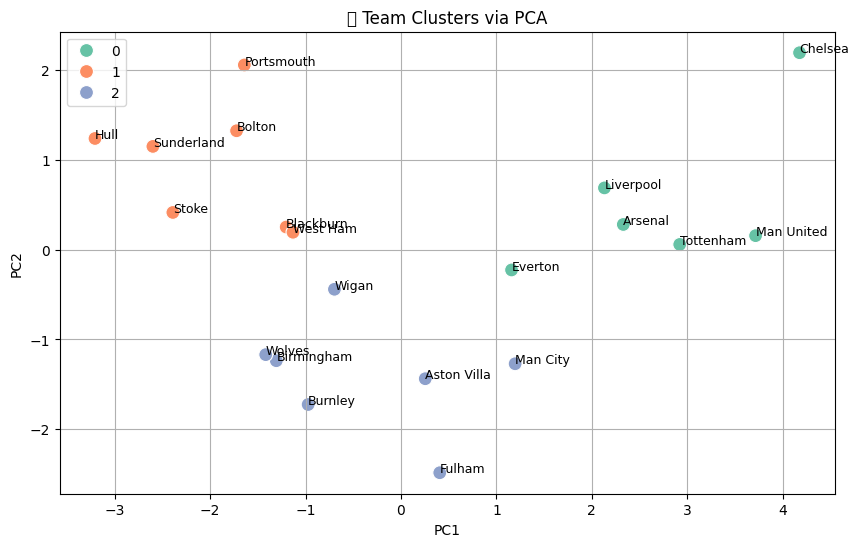

In [35]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2', s=100)
for i, team in enumerate(team_stats.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], team, fontsize=9)
plt.title("🔍 Team Clusters via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()